In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [14]:
teams_model = pd.read_csv("data_models/teams_model.csv")

R²: 0.857
RMSE: 1.88


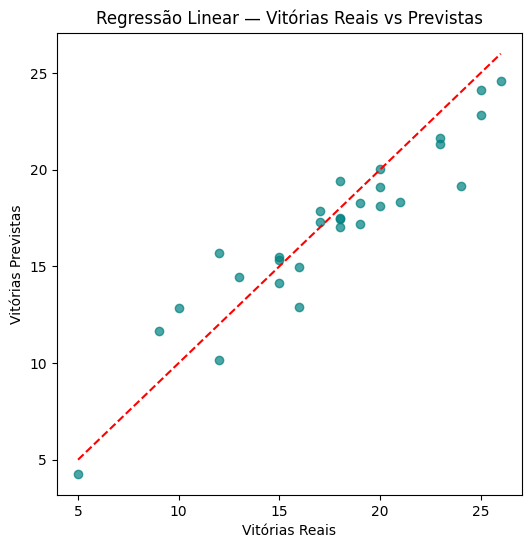

   year tmID  won   pred_won  pred_rank
0     9  ATL    4   5.052138       14.0
1    10  ATL   18  19.402732        3.0
2     1  CHA    8   7.798412       15.0
3     2  CHA   18  18.003662        7.0
4     3  CHA   18  19.414259        3.0
5     4  CHA   18  16.921432        8.0
6     5  CHA   16  13.772366       12.0
7     6  CHA    6   7.867771       12.0
8     7  CHA   11  12.735254       11.0
9     7  CHI    5   4.274507       14.0


In [15]:
# ===============================================================
# 🧩 Alinea (a) — Previsão do Ranking da Regular Season
# ===============================================================


# Usando dados como pontos marcados, sofridos, eficiência ofensiva/defensiva e rebotes, prever quantas vitórias uma equipa terá numa temporada


# 4️⃣ Definir variáveis (X = features, y = alvo)
features = ["o_pts", "d_pts", "point_diff", "off_efficiency", "def_efficiency", "rebalance"]
X = teams_model[features]
y = teams_model["won"]

# 5️⃣ Separar treino e teste (para avaliação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6️⃣ Treinar modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# 7️⃣ Fazer previsões
y_pred = model.predict(X_test)

# 8️⃣ Avaliar performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

# 9️⃣ Visualizar previsões vs valores reais
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Vitórias Reais")
plt.ylabel("Vitórias Previstas")
plt.title("Regressão Linear — Vitórias Reais vs Previstas")
plt.show()

# 🔟 Gerar ranking previsto
teams_model["pred_won"] = model.predict(X)
teams_model["pred_rank"] = teams_model.groupby("year")["pred_won"].rank(ascending=False)

# Mostrar primeiros resultados
print(teams_model[["year", "tmID", "won", "pred_won", "pred_rank"]].head(10))
